# Final Submission: ML Models and Statistical Methods
* Kickstarter Team Members: Allison Bass, Dylan Juarez, Prakash Rao, Franklin Tan, and Alfonso Alday Vergara
* Submission Date: August 9, 2023

## Key Question: What are the factors driving project failure at Kickstarter?

### Most of Kickstarter's projects are failing. Despite platform's growth, successful projects have remained stagnant.
**After executing an in-depth analysis, we identified 4 key aspects that the organization can focus on to improve success rates and profits across the board:**
1. Increasing the number of organic backers in the platform to increase the effect of social proof.
2. Guide creators to find the optimal goal for their project.
3. Implement marketing tactics to avoid seasonality effects.
4. Encouraging backers to pledge more every time they back a project.<br>

**The findings were obtained using the following machine learning models and statistical methods: Logistic Regression, Decision trees, LightGBM, ANOVA, and Tukey's HSD Test.**
* Logistic Regression, Decision trees, LightGBM, ANOVA, and Tukey's HSD Test.

**Please refer to the following presentation for an in-depth look into our business story and detailed client recommendations**<br>
* [See PPT Link](https://cornellprod-my.sharepoint.com/:p:/r/personal/ab2597_cornell_edu/_layouts/15/Doc.aspx?sourcedoc=%7B6908AD95-FEAF-48B9-AD67-16CB7C6BE968%7D&file=Final%20Capstone%20Presentation.pptx&action=edit&mobileredirect=true)

## Loading Libraries and Dataset

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
# Load the CSV dataset
df = pd.read_csv('../inputs/kickstarter_projects.csv')

In [3]:
# Set the Display to Show all Columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Look at Original Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
# Copy Original Dataframe
df2 = df.copy()
df2.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,10/9/15,1000.0,8/11/15 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,11/1/17,30000.0,9/2/17 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2/26/13,45000.0,1/12/13 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,4/16/12,5000.0,3/17/12 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,8/29/15,19500.0,7/4/15 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data Preprocessing and Feature Engineering

In [19]:
# Drop all rows that contain any null values
df2 = df2.dropna()

# Create Dependent Variable State
df2['target'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

# Feature Extraction
df2['launched'] = pd.to_datetime(df2['launched'])
df2['deadline'] = pd.to_datetime(df2['deadline'])
df2['duration'] = (df2['deadline'] - df2['launched']).dt.days

# Extract year-month and convert to string
df2['launched_year_month'] = df2['launched'].dt.to_period('M').astype(str)
df2['deadline_year_month'] = df2['deadline'].dt.to_period('M').astype(str)

# Convert Datetime columns to categorical columns
date_time_cols = ['launched_year_month', 'deadline_year_month']
df2[date_time_cols] = df2[date_time_cols].astype('category')

# Create New Dataframe and Drop Irrelevant Columns
df3 = df2.drop(['target', 
                'main_category',
                'country',
                'category',
                'ID', 
                'name',
                'currency',
                'deadline',
                'goal',
                'launched',
                'pledged',
                'state',
                'usd pledged',
                'launched_year_month', 
                'deadline_year_month'
                ], axis=1)

# Separate the numerical columns to be standardized
num_cols = ['usd_goal_real', 'usd_pledged_real', 'backers', 'duration']

# Standardize the numerical columns
scaler = StandardScaler()
df3[num_cols] = scaler.fit_transform(df3[num_cols])

# Apply log1p transformation to each numerical feature
for col in num_cols:
    df3[col] = df3[col].apply(lambda x: np.log1p(x) if x >= -1 else x)

# Create an imputer object that will impute 'NaN' values with the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply the imputer to your dataframe
df3 = pd.DataFrame(imputer.fit_transform(df3), columns=df3.columns)

**We did the above data preprocessing and feature engineering steps for the following reasons:**<br>
1. Since we only had a small number of null values in our Kickstarter dataset, we decided to drop them. 
2. We created a binary dependent variable, "target," with the value 1 for project failure and 0 for project success. We made this decision because of Kickstarter's all-or-nothing business model (i.e., If a Kickstarter project does not reach its funding goal by the end of the campaign, no money changes hands and Kickstarter does not earn any revenue) and our team's interest in understanding the factors driving Kickstarter project failure.
3. We converted the "launch" and "deadline" Kickstarter fields to datetimes in order to create a "duration" independent variable. 
4. We dropped independent variables we decided not to include in our machine learning models. 
5. We normalized and log transformed our numerical independent variables to increase our gradient descent optimization speed (for logistic regression) and fix distributional skews. 
6. We created an imputer object just in case we had any NaN stragglers.

## Logistic Regression

In [33]:
# Define target and features
X = df3
y = df2['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Create a Logistic Regression model with class_weight='balanced'
logreg_model = LogisticRegression(random_state=100, class_weight='balanced')

# Fit the model on the training data
logreg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9156396165679631


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     72134
           1       0.90      0.86      0.88     40324

    accuracy                           0.92    112458
   macro avg       0.91      0.90      0.91    112458
weighted avg       0.92      0.92      0.92    112458



**Based on the results from the logistic regression model, we can interpret the following:**

* Accuracy: The overall accuracy of the model is approximately 92%, which means that it correctly predicts the target class for about 92% of the total instances in the dataset.

* Precision: For class 0 (the first class), the precision is 0.92, indicating that 92% of the instances predicted as class 0 are actually true positives. For class 1 (the second class), the precision is 0.90, indicating that 90% of the instances predicted as class 1 are true positives.

* Recall (Sensitivity or True Positive Rate): For class 0, the recall is 0.95, meaning that the model correctly identifies 95% of the instances of class 0. For class 1, the recall is 0.86, meaning that the model correctly identifies 86% of the instances of class 1.

* F1-Score: For class 0, the F1-score is 0.94, and for class 1, the F1-score is 0.88.

* Support: For class 0, there are 72,134 instances, and for class 1, there are 40,324 instances.

* Macro Avg: The macro average precision, recall, and F1-score are all around 0.91.

* Weighted Avg: The weighted average calculates the average precision, recall, and F1-score, taking into account the number of instances in each class. The weighted average precision, recall, and F1-score are all approximately 0.92.

In summary, the logistic regression model is performing well with high accuracy and reasonable precision, recall, and F1-scores for both classes. The model is better at predicting class 1 (higher recall and F1-score) than class 0.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.221956
         Iterations 13
Coefficients:
const               -20.356107
backers              17.097824
usd_pledged_real     83.008365
usd_goal_real      -755.784847
duration             -0.007271
dtype: float64


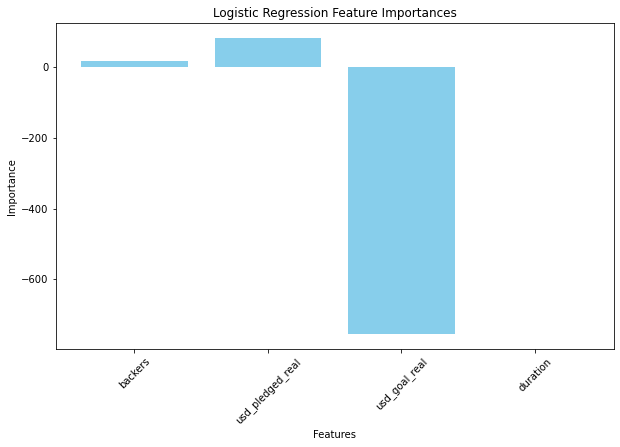

In [34]:
# Extract coefficients and p-values using statsmodels
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Coefficients
coefficients = result.params
print("Coefficients:")
print(coefficients)

# Sample data for demonstration purposes
df3_columns = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']
importances = [17.097, 83.00, -755.784, -0.007]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df3_columns, importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Logistic Regression Feature Importances')
plt.xticks(rotation=45)
plt.show()

**Analysis**<br>
1. **const (Constant):** The intercept term in the logistic regression model.

2. **backers:** For every one-unit increase in the "backers" variable, the log-odds of the event (e.g., success) occurring increases by approximately 17.10 units, assuming all other variables remain constant. This suggests that an increase in the number of backers is associated with an increase in the odds of the event happening.

3. **usd_pledged_real:** For every one-unit increase in the "usd_pledged_real" variable, the log-odds of the event occurring increases by approximately 83.01 units, holding all other variables constant. This indicates that a higher amount pledged in USD is associated with higher odds of the event happening.

4. **usd_goal_real:** For every one-unit increase in the "usd_goal_real" variable, the log-odds of the event occurring decreases by approximately 755.78 units, assuming all other variables remain constant. This suggests that a higher funding goal in USD is associated with lower odds of the event happening.

5. **duration:** For every one-unit increase in the "duration" variable, the log-odds of the event occurring decreases by approximately 0.007 units, while holding all other variables constant. This indicates a slight decrease in the odds of the event happening with a longer duration.

In [18]:
# P-values
p_values = result.pvalues
print("P-values:")
print(p_values)

P-values:
const               0.000000
backers             0.000000
usd_pledged_real    0.000000
usd_goal_real       0.000000
duration            0.115213
dtype: float64


**Analysis**<br> In summary, all the independent variables except "duration" appear to be highly statistically significant in predicting the outcome in this logistic regression model. "Duration" does not reach the traditional significance level, but its inclusion in the model may still be considered based on the specific objectives and context of the analysis.

## Decision Tree

In [26]:
# Define target and features
X = df3
y = df2['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the hyperparameter grid for grid search
param_grid = {
    'max_depth': [1,2,3],             # Test different maximum depths
    'min_samples_split': [10,20,30],
    'min_samples_leaf': [1,2,5,10,20],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=100, class_weight='balanced')

# Create the GridSearchCV object
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Create the final pruned Decision Tree model with the best hyperparameters
final_dt_model = DecisionTreeClassifier(
    random_state=100,
    class_weight='balanced',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    ccp_alpha = best_params['ccp_alpha']
)

# Fit the final model on the training data
final_dt_model.fit(X_train, y_train)

# Make predictions on the test data using the final pruned model
y_pred_dt = final_dt_model.predict(X_test)

# Evaluate the final model
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Best hyperparameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     72134
           1       0.80      0.96      0.88     40324

    accuracy                           0.90    112458
   macro avg       0.89      0.92      0.90    112458
weighted avg       0.92      0.90      0.90    112458



**The hyperparameters are the settings that were found to give the best performance for the Decision Tree model during the hyperparameter tuning process. The values given are:**
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 1, and min_samples_split: 10

**Based on the results from Decision Tree Model, we can interpret the following:**

* Accuracy: The overall accuracy of the model is approximately 90%, which means that it correctly predicts the target class for about 90% of the total instances in the dataset.

* Precision: For class 0 (the first class), the precision is 0.98, indicating that 98% of the instances predicted as class 0 are actually true positives. For class 1 (the second class), the precision is 0.80, indicating that 80% of the instances predicted as class 1 are true positives.

* Recall (Sensitivity or True Positive Rate): For class 0, the recall is 0.87, meaning that the model correctly identifies 87% of the instances of class 0. For class 1, the recall is 0.96, meaning that the model correctly identifies 96% of the instances of class 1.

* F1-Score: For class 0, the F1-score is 0.92, and for class 1, the F1-score is 0.88.

* Support: For class 0, there are 72,134 instances, and for class 1, there are 40,324 instances.

* Macro Avg: The macro average precision, recall, and F1-score are all around 0.91.

* Weighted Avg: The weighted average precision, recall, and F1-score are all approximately 0.91.

Overall, the model seems to perform reasonably well with an accuracy of 90%. It has better precision for class 0 (negative class) but better recall for class 1 (positive class). The hyperparameters used for the model were found through tuning and appear to provide a good balance between complexity and performance.

Feature importances:
backers: 0.6633144923160833
usd_pledged_real: 0.24259509779222374
usd_goal_real: 0.094090409891693
duration: 0.0


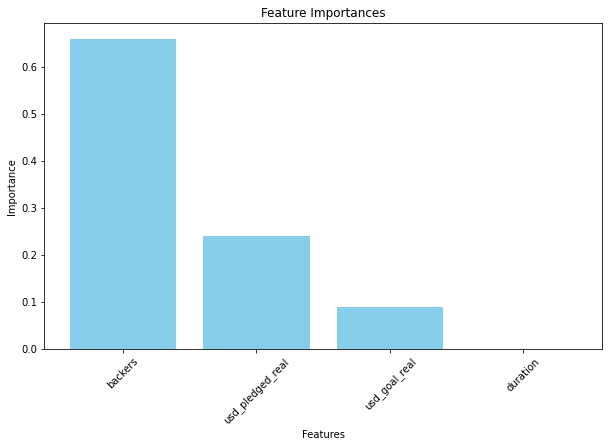

In [30]:
# Get feature importances from the final model
importances = final_dt_model.feature_importances_
print("Feature importances:")
for col, imp in zip(df3.columns, importances):
    print(f"{col}: {imp}")
    
# Sample data for demonstration purposes
df3_columns = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']
importances = [0.66, 0.24, 0.09, 0.0]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df3_columns, importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

**Analysis**
1. backers: 63.33% of the information in the tree comes from the backers variable, making it the most important feature. 
2. usd_pledged_real: 24.26% of the information in the tree comes from the usd_pledged_real, making it the second most important feature. 
3. usd_goal_real: 9.41% of the information in the tree comes from usd_goal_real, which is a significantly lower feature importance score compared to backers and usd_pledged_real. 
4. Duration: 0% of the information in the tree comes from duration, meaning that it doesn't contribute anything to predicting Kickstarter project failure.